In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# modify the path below accordingly
PATH = "/content/drive/MyDrive/compvision/gesture_face_features"

In [4]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.7 MB/s eta 0:00:00


In [42]:
# importing .py files from /code
import sys
import os
sys.path.append(os.path.join(PATH, "code"))

%load_ext autoreload
%autoreload 2

from utils import show_img, plot_imgs
from config import Config, available_models
from heatmap import *
from hand_extraction import extract_hand_mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
configs = {}
img_type="sign"
letter = "N"
first_model = available_models[next(iter(available_models))]

for model_name in available_models.values():
  print("Configuring model", model_name, "for", img_type, "for letter", letter)
  load_data = model_name == first_model # Loading data only for the first model
  conf = Config(PATH, img_type=img_type, letter=letter, model_name=model_name, load_data=load_data)
  if not load_data:
    conf.sign_imgs = [img.copy() for img in configs[first_model].sign_imgs] # copying data from the first model to others
  configs[model_name] = conf
  print()

Configuring model ResNet50 for sign for letter N
Loading data...
Data loaded successfully.
Setting up model ResNet50...
Model was set up successfully.

Configuring model InceptionV3 for sign for letter N
Setting up model InceptionV3...
Model was set up successfully.

Configuring model EfficientNetB0 for sign for letter N
Setting up model EfficientNetB0...
Model was set up successfully.

Configuring model EfficientNetB1 for sign for letter N
Setting up model EfficientNetB1...
Model was set up successfully.

Configuring model EfficientNetB6 for sign for letter N
Setting up model EfficientNetB6...
Model was set up successfully.



In [9]:
# for model_name, conf in configs.items():
#   print("Generating 2 heatmaps for", model_name, "for the sign", letter)
#   print(conf)
#   generate_heatmaps(conf.sign_imgs[:2], conf.input_dim, *conf.heatmap_config)

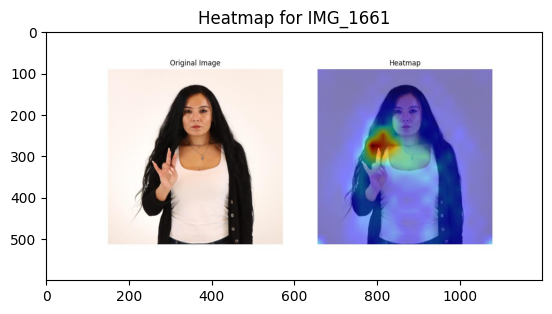

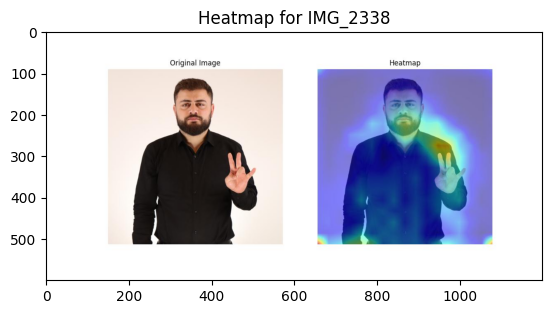

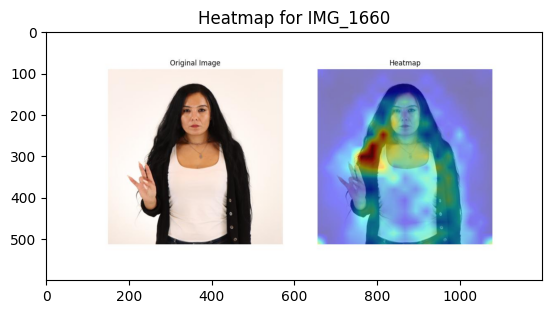

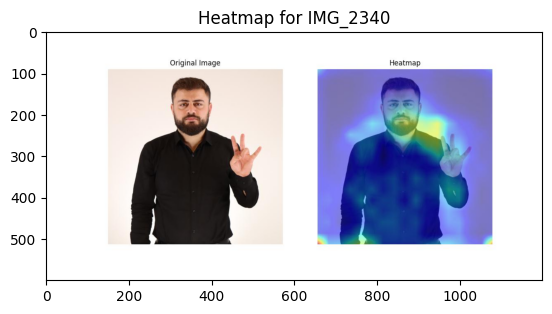

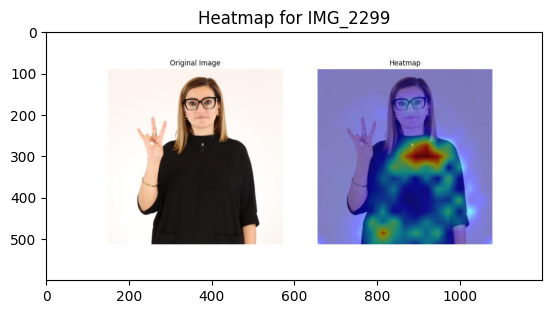

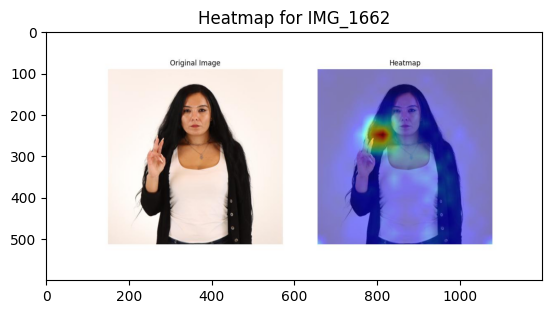

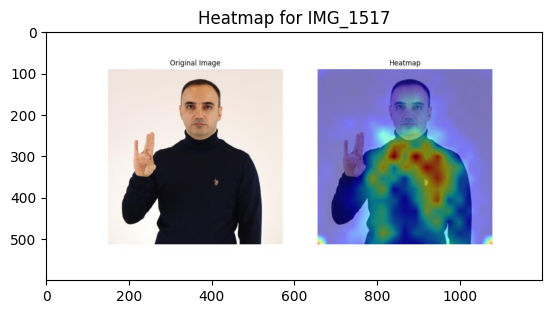

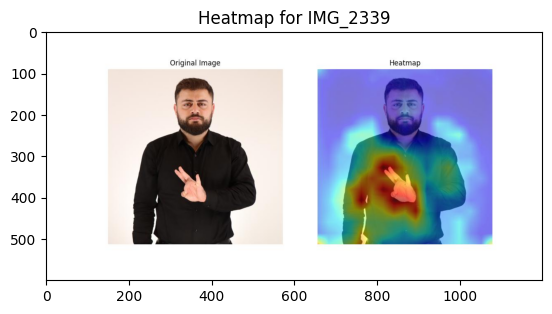

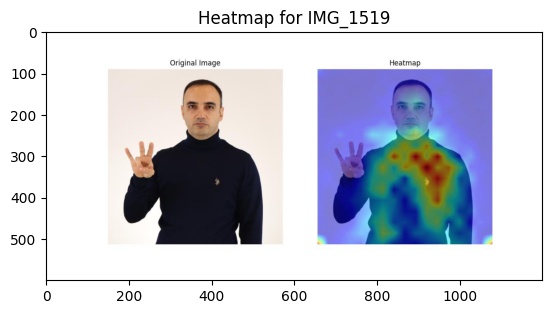

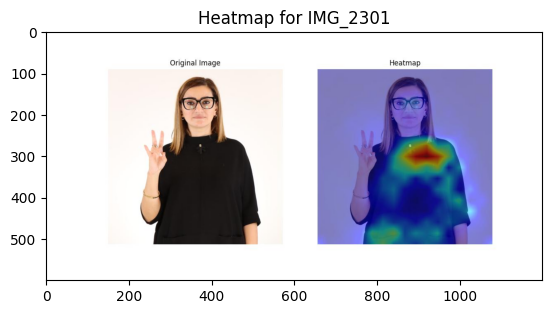

In [31]:
enetB6 = configs['EfficientNetB6']
# generate_heatmaps(enetB6.sign_imgs, enetB6.input_dim, *enetB6.heatmap_config, enetB6.heatmaps_path)
load_heatmaps(enetB6.sign_img_paths[:10], enetB6.heatmaps_path)

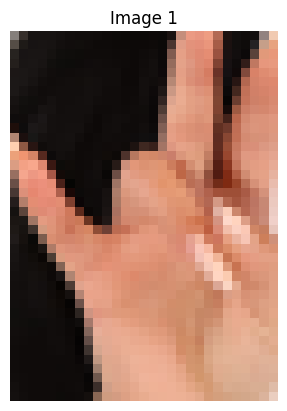

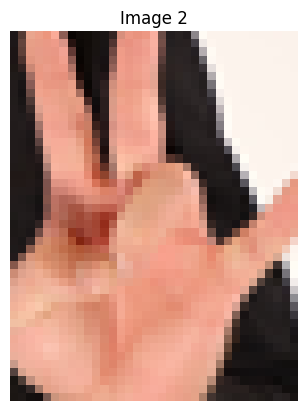

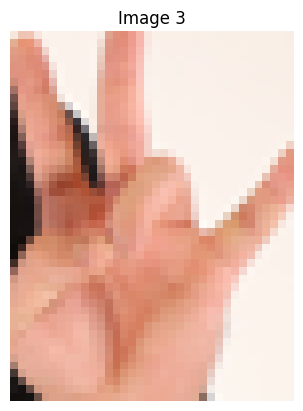

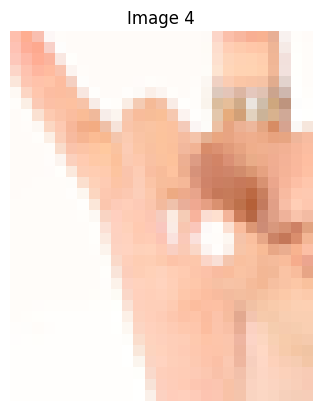

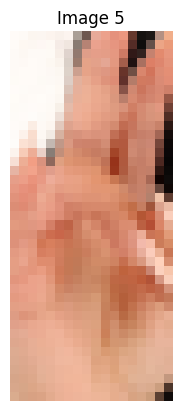

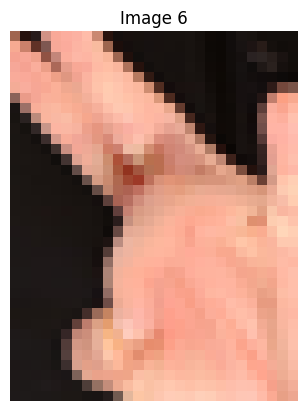

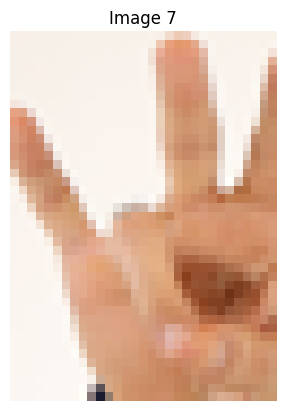

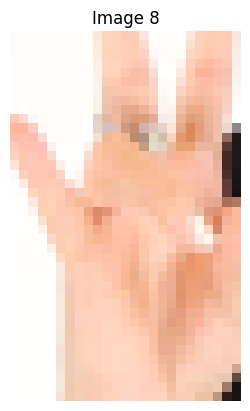

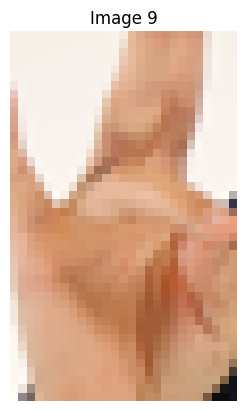

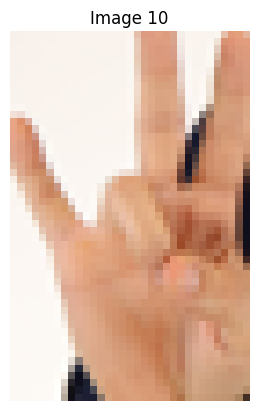

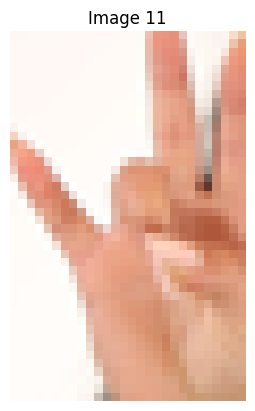

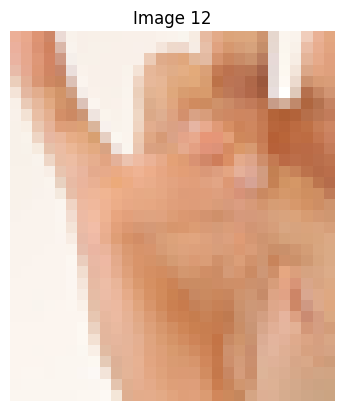

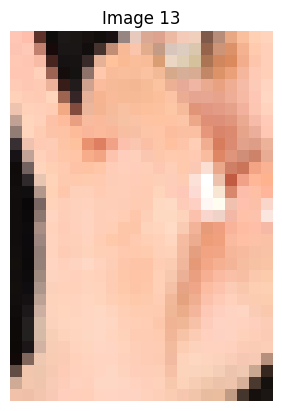

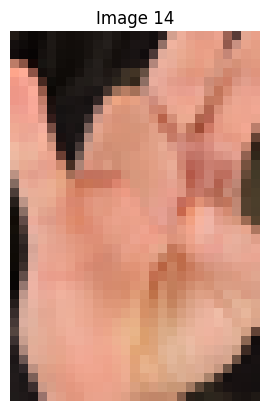

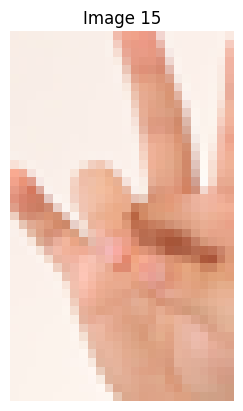

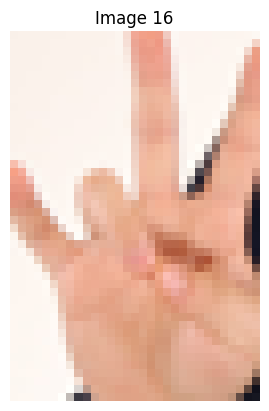

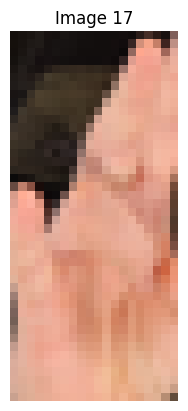

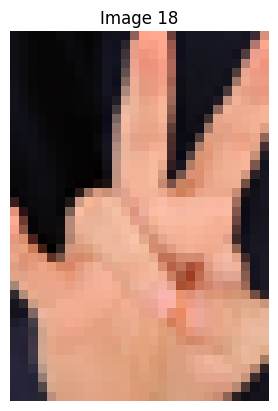

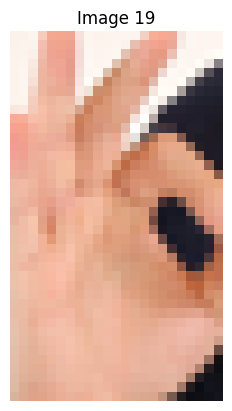

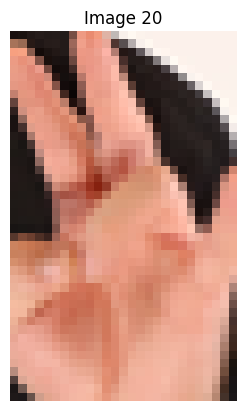

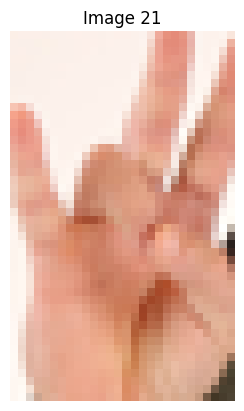

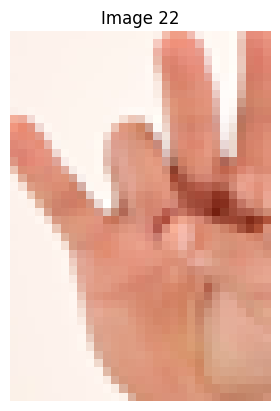

In [47]:
hand_path = os.path.join(PATH, "cropped_hands")
# extract_hand_mp(enetB6.sign_imgs, (224, 224), output_path=hand_path)
plot_imgs(hand_path)